In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#HASH RATE
hash_rate = pd.read_csv("data/bitcoin-mean-hash-rate.csv")

hash_rate["Hash Rate/t"] = hash_rate["Hash Rate/t"].str.rstrip("T00:00:00.000Z")
hash_rate["Hash Rate/t"] = pd.to_datetime(hash_rate["Hash Rate/t"])
hash_rate = hash_rate.sort_values(by='Hash Rate/t')
hash_rate = hash_rate.rename(columns={'Hash Rate/t': 'Timestamp', 'Hash Rate/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
hash_rate = hash_rate[~(hash_rate['Timestamp'] < '2010-01-01')]
hash_rate = hash_rate[~(hash_rate['Timestamp'] > '2021-12-31')]

#reset index
hash_rate = hash_rate.reset_index()

#Description
print(hash_rate.head())
print("\nShape is:", hash_rate.shape)
print("\nSummary of the dataset:")
hash_rate.describe()
print("\nAre there null values?")
hash_rate.isna().sum()

   index  Timestamp         Value
0    357 2010-01-01  5.948447e+06
1    366 2010-01-01  1.116364e+07
2    358 2010-01-02  5.272979e+06
3    376 2010-01-02  1.015796e+07
4    359 2010-01-03  1.091864e+07

Shape is: (4383, 3)

Summary of the dataset:

Are there null values?


index        0
Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
hash_rate['year'] = [d.year for d in hash_rate["Timestamp"]]

In [4]:
hash_rate.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021])

In [5]:
hash_rate.year.value_counts()

2012    366
2016    366
2020    366
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
Name: year, dtype: int64

# VISUALIZATION

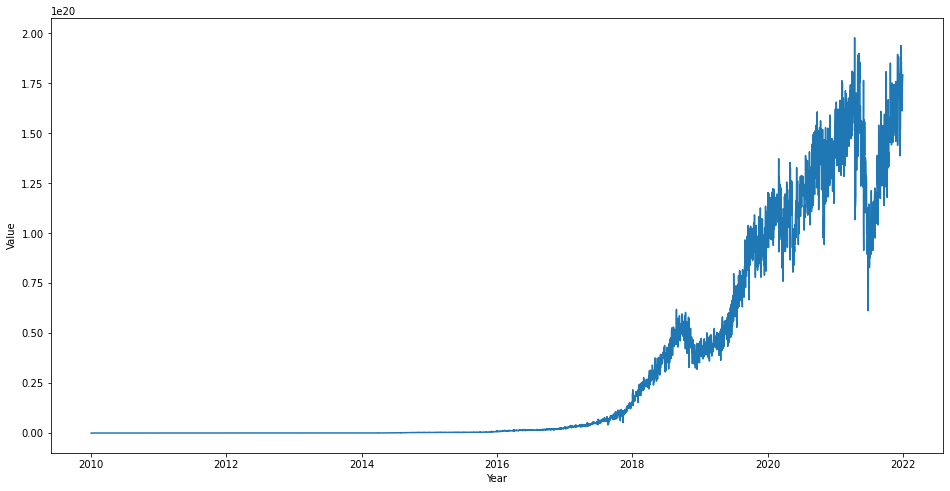

In [6]:
plt.figure(figsize=(16,8))
plt.plot(hash_rate["Timestamp"], hash_rate["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


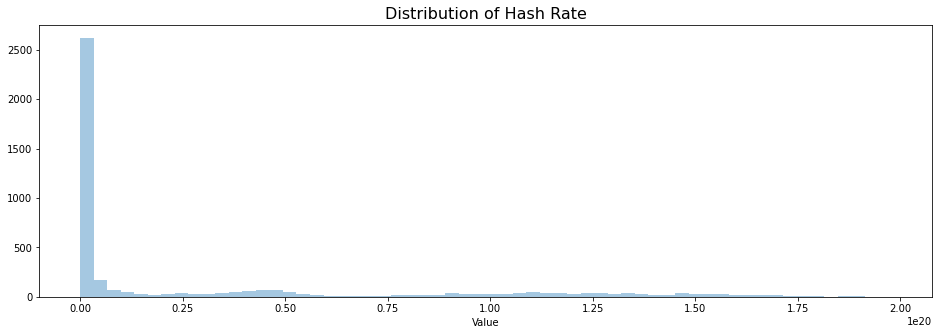

In [7]:
plt.figure(figsize=(16,5))
sns.distplot(hash_rate["Value"], kde = False, bins = 60)
plt.title('Distribution of Hash Rate', fontsize=16)
plt.show()

#### Shorter time series
Same as market price

In [8]:
hash_rate["Value"][hash_rate["Timestamp"].dt.year == 2014].mean()
hashh = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2016) & (hash_rate["Timestamp"].dt.year < 2022),:]
hashn = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2016) & (hash_rate["Timestamp"].dt.year < 2021),:]
hashnh = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2012) & (hash_rate["Timestamp"].dt.year < 2021),:]
hashf = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2012) & (hash_rate["Timestamp"].dt.year < 2022),:]

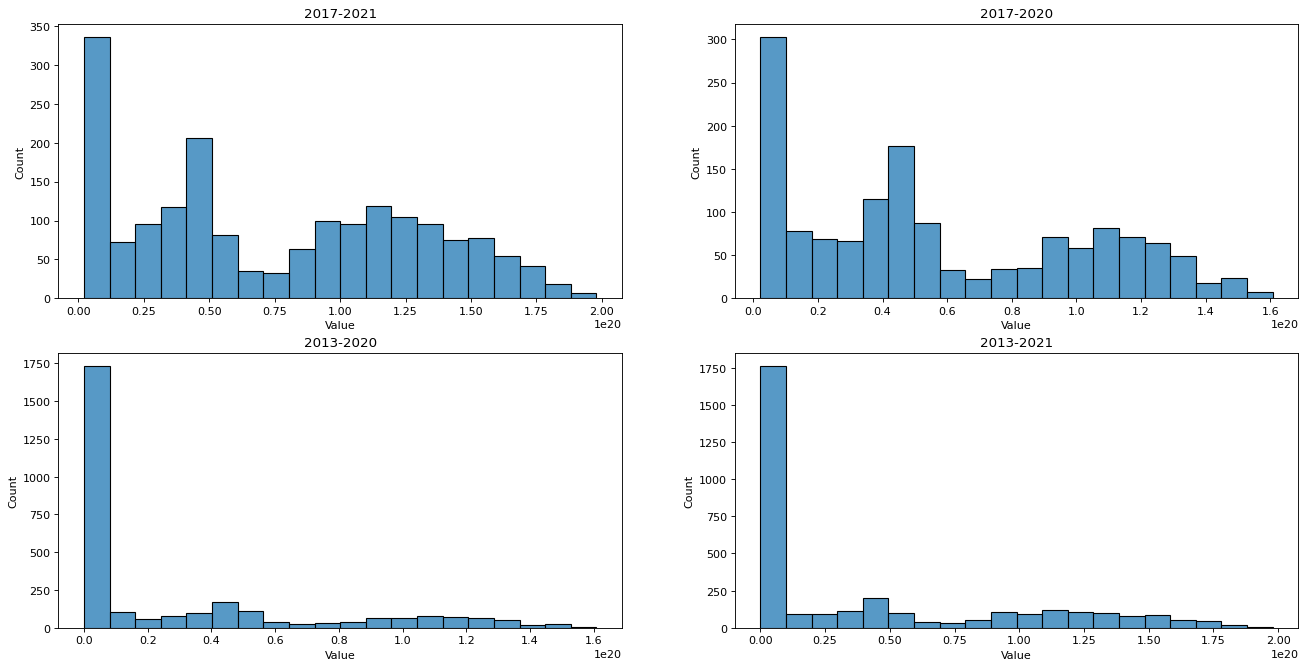

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(hashh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(hashn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(hashnh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(hashf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

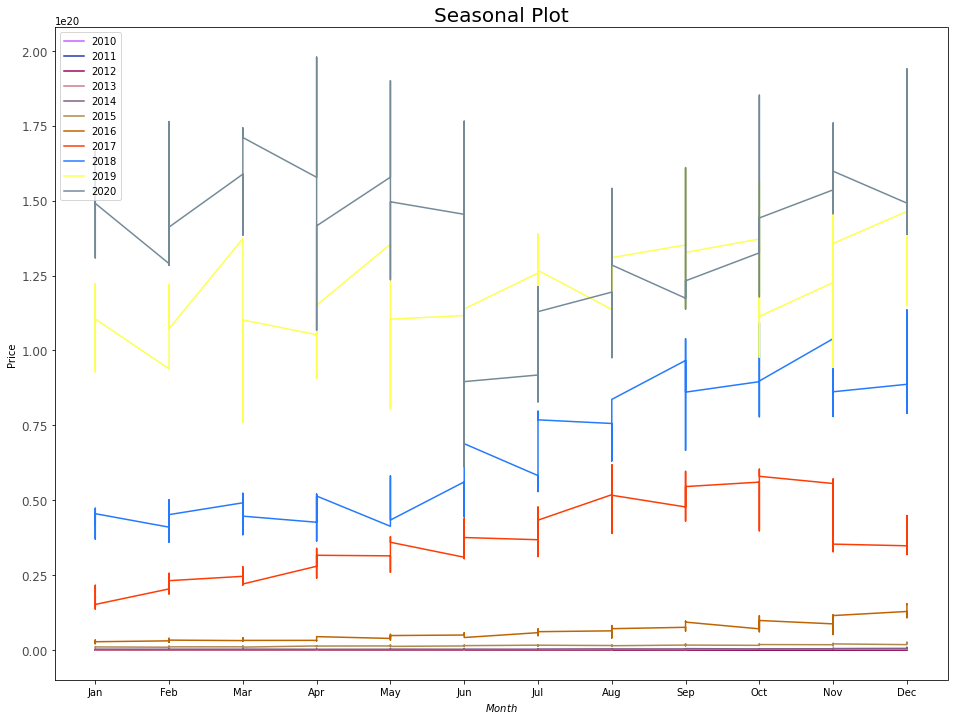

In [10]:
# Prepare data
hash_rate['year'] = [d.year for d in hash_rate["Timestamp"]]
hash_rate['month'] = [d.strftime('%b') for d in hash_rate["Timestamp"]]
years = hash_rate['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=hash_rate.loc[hash_rate.year==y, :], color=mycolors[i], label=y)
        #plt.text(market_price.loc[market_price.year==y, :].shape[0]-.9, market_price.loc[market_price.year==y, "Price"][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

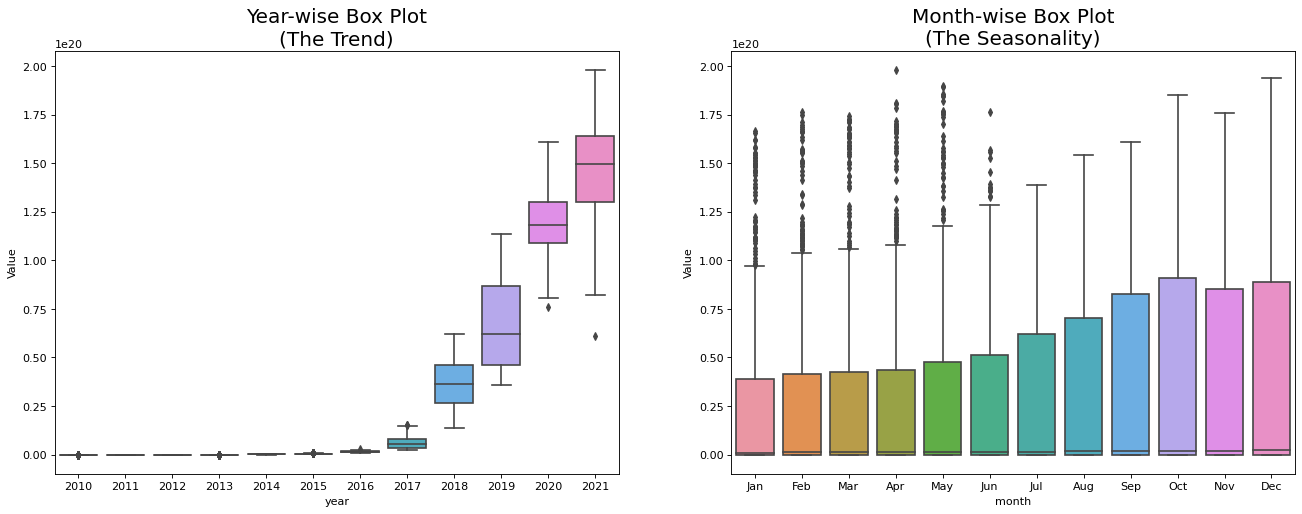

In [11]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=hash_rate, ax=axes[0])
sns.boxplot(x='month', y="Value", data=hash_rate.loc[~hash_rate.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [12]:
hash_rate["Value"]

0       5.948447e+06
1       1.116364e+07
2       5.272979e+06
3       1.015796e+07
4       1.091864e+07
            ...     
4378    1.614002e+20
4379    1.788373e+20
4380    1.613201e+20
4381    1.749405e+20
4382    1.791817e+20
Name: Value, Length: 4383, dtype: float64

Text(0.5, 0.98, 'HASH RATE / 2013-2021 ')

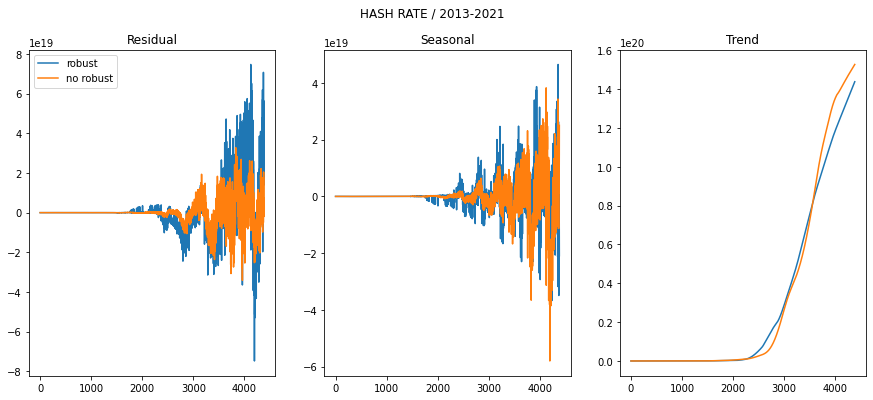

In [13]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(hash_rate["Value"], period=365, robust=True).fit()
res2 = STL(hash_rate["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('HASH RATE / 2013-2021 ')

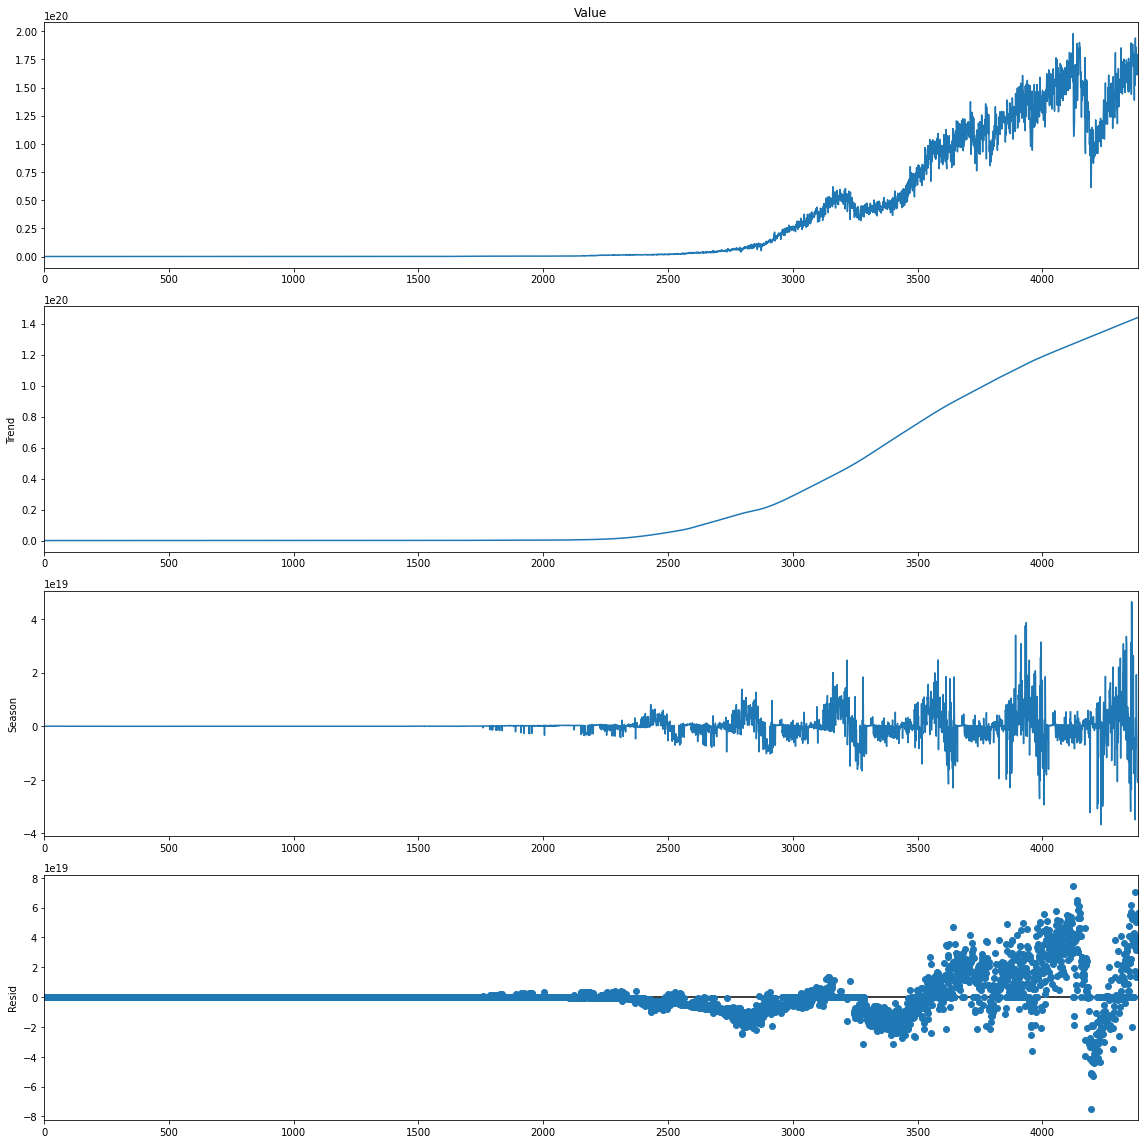

In [14]:
fig = res1.plot() #BIGGER VIEW

Text(0.5, 0.98, 'HASH RATE / 2017-2021 ')

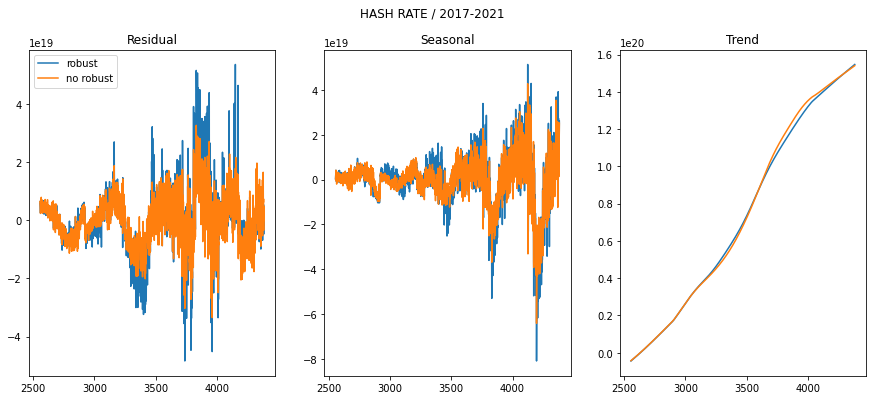

In [15]:
plt.rc("figure", figsize=(16, 16))
res3 = STL(hashh["Value"], period=365, robust=True).fit()
res4 = STL(hashh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('HASH RATE / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [16]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA (CELLA GIU' PER SUPERARE IL PROBLEMA)

In [17]:
np.log(res3.trend)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2557          NaN
2558          NaN
2559          NaN
2560          NaN
2561          NaN
          ...    
4378    46.486403
4379    46.486756
4380    46.487108
4381    46.487459
4382    46.487811
Name: trend, Length: 1826, dtype: float64

In [18]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(hashh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(hashh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([2.00008432e-03, 4.35012235e+01])

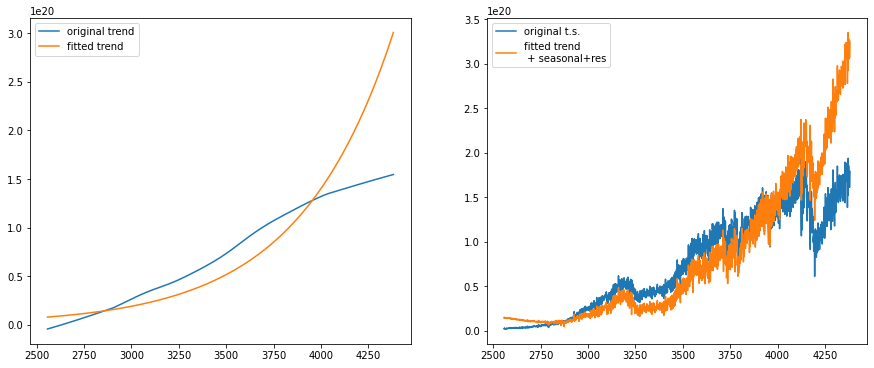

In [19]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(hashh))+1)), index = hashh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(hashh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# Stationarity Test - Augmented Dickey Fuller test (ADH Test)

ADH: null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [20]:
# ADF Test
result = adfuller(hash_rate["Value"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 2.730134738699497
p-value: 0.9990880137295759
Critial Values:
   1%, -3.4318531381537225
Critial Values:
   5%, -2.8622042027970633
Critial Values:
   10%, -2.5671235596834574


# ACF-PACF plots and order of differencing

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


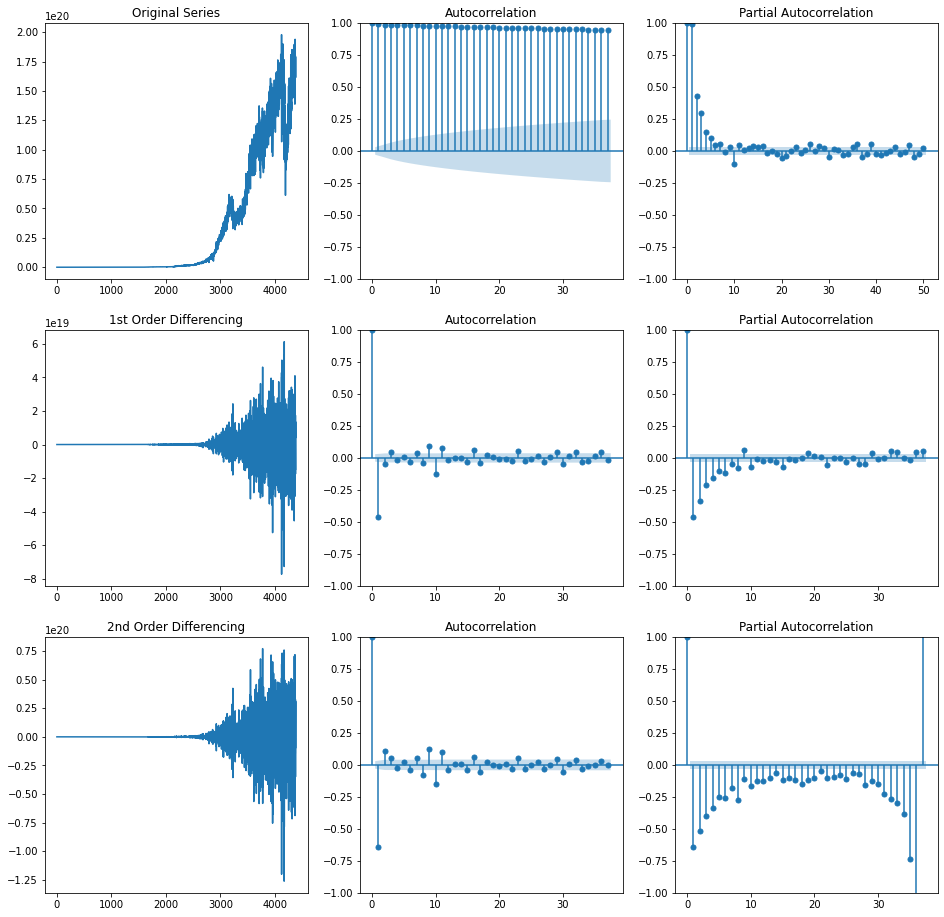

In [21]:
# Original Series
fig, axes = plt.subplots(3, 3)
axes[0, 0].plot(hash_rate["Value"]); axes[0, 0].set_title('Original Series')
plot_acf(hash_rate["Value"], ax=axes[0, 1])
plot_pacf(hash_rate["Value"], lags=50, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(hash_rate["Value"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(hash_rate["Value"].diff().dropna(), ax=axes[1, 1])
plot_pacf(hash_rate["Value"].diff().dropna(), ax=axes[1, 2])


# 2nd Differencing
axes[2, 0].plot(hash_rate["Value"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(hash_rate["Value"].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(hash_rate["Value"].diff().diff().dropna(), ax=axes[2, 2])

plt.show()

In [22]:
hash_rate# ADF Test for 1 order of differencing
result = adfuller(hash_rate["Value"].diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -13.397956791958428
p-value: 4.626854526428539e-25
Critial Values:
   1%, -3.4318541754134206
Critial Values:
   5%, -2.8622046610228353
Critial Values:
   10%, -2.5671238036200292


In [23]:
hash_rate# ADF Test for 2 order of differencing
result = adfuller(hash_rate["Value"].diff().diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -24.51816070226378
p-value: 0.0
Critial Values:
   1%, -3.4318545214848486
Critial Values:
   5%, -2.862204813905292
Critial Values:
   10%, -2.567123885007038


# Model building

Steps
- Transform the data using box-cox transformation
- Split data in train-test dataset
- Model 1 - ARIMA
- Model 2 - SARIMA
- Model 3 - SARIMAX
- Model 4 - Simple Exponential Smoothing
- Model 5 - Holt-Winters
- Define function to evaluate models
- Train and evaluate the model
- Save the model

### Box-Cox Tranformation

Transform the data to be normally distributed

In [24]:
# Box-cox transformation flag
input_transform_flag = 'Yes' # choose if you wish to transform the data - 'Yes' or 'No'

In [25]:
hash_rate.head()

,index,Timestamp,Value,year,month
0,357,2010-01-01,5.948447e+06,2010,Jan
1,366,2010-01-01,1.116364e+07,2010,Jan
2,358,2010-01-02,5.272979e+06,2010,Jan
3,376,2010-01-02,1.015796e+07,2010,Jan
4,359,2010-01-03,1.091864e+07,2010,Jan


In [26]:
# Box - Cox Transform
if input_transform_flag == 'Yes':
    hash_rate["Value"], my_lambda = boxcox(hash_rate["Value"])
else:
    print("No transformation")

/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [27]:
hash_rate.head()

,index,Timestamp,Value,year,month
0,357,2010-01-01,29.411458,2010,Jan
1,366,2010-01-01,31.462963,2010,Jan
2,358,2010-01-02,29.029479,2010,Jan
3,376,2010-01-02,31.149175,2010,Jan
4,359,2010-01-03,31.389007,2010,Jan


### Train - Test Window Split

Split the dataset in training and test set

In [28]:
train_pct = 0.70
train_size = int(len(hash_rate) * train_pct)
test_size = len(hash_rate) - train_size
train, test = hash_rate[0:train_size], hash_rate[train_size:]

### Model 1 - ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

The initial order of the ARIMA model can be determined using the the ACF and PACF plots. The initial starting point for 'p' is the number of significant lags from the PACF plot and 'q' comes from the number of significant lags from the ACF plot.

You might want to check the error for serial correlation using the Durbin-Watson statistic and ch

I will demonstrate the code in upcoming section.

### Model 2 - SARIMA

If a time series has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

I will demonstrate the code in next section

### Model 3 - SARIMAX

If a time series has seasonal patterns and an external predictor (also called as exogenous variable), then you need to add seasonal and exogenous terms and it becomes SARIMAX

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

Since ARIMA, SARIMA and SARIMAX are from the same family. I have defined a single function to fit these models automatically.

In [29]:
input_target_variable = "Value"
train[input_target_variable]

0        29.411458
1        31.462963
2        29.029479
3        31.149175
4        31.389007
           ...    
3063    364.737751
3064    363.715984
3065    365.498999
3066    362.396777
3067    369.099191
Name: Value, Length: 3068, dtype: float64

In [30]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(train[input_target_variable], exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

You can fit in the parameters manually as well.

In [31]:
def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

### Define function to get the predictions

In [32]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

### Define function to evaluate models

- Durbin Watson Statistic
- MAPE
- MAE
- RSME
- R2 Score

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
def durbin_watson_stat(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    return(durbin_watson(validation_df.error))

In [35]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [36]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))
    print("Durbin Watson Score : ", durbin_watson_stat(actuals, predictions))
    
    analyse_error(actuals, predictions)
    
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

In [37]:
# Forecasting algorithm
input_ts_algo = 'auto_arima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'

In [38]:
input_seasonality = 12

------------- Auto ARIMA --------------- 

Performing stepwise search to minimize aic


/usr/local/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12759.758, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14108.718, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13226.206, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12757.961, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14113.178, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12759.784, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12759.991, Time=1.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12869.046, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.390 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3068
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -6375.980
Date:                Fri, 23 Sep 2022   AIC                          12757.961
Time:                        17:31:13   BIC                          12

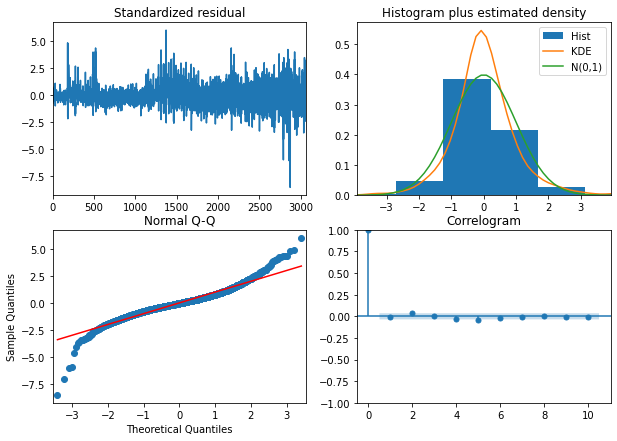

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  10.758296890064576
MAE  :  43.21650273949536
RMSE  :  51.58017099571381
R2 Score  :  -10.690625135150933
Durbin Watson Score :  0.005276384675653324


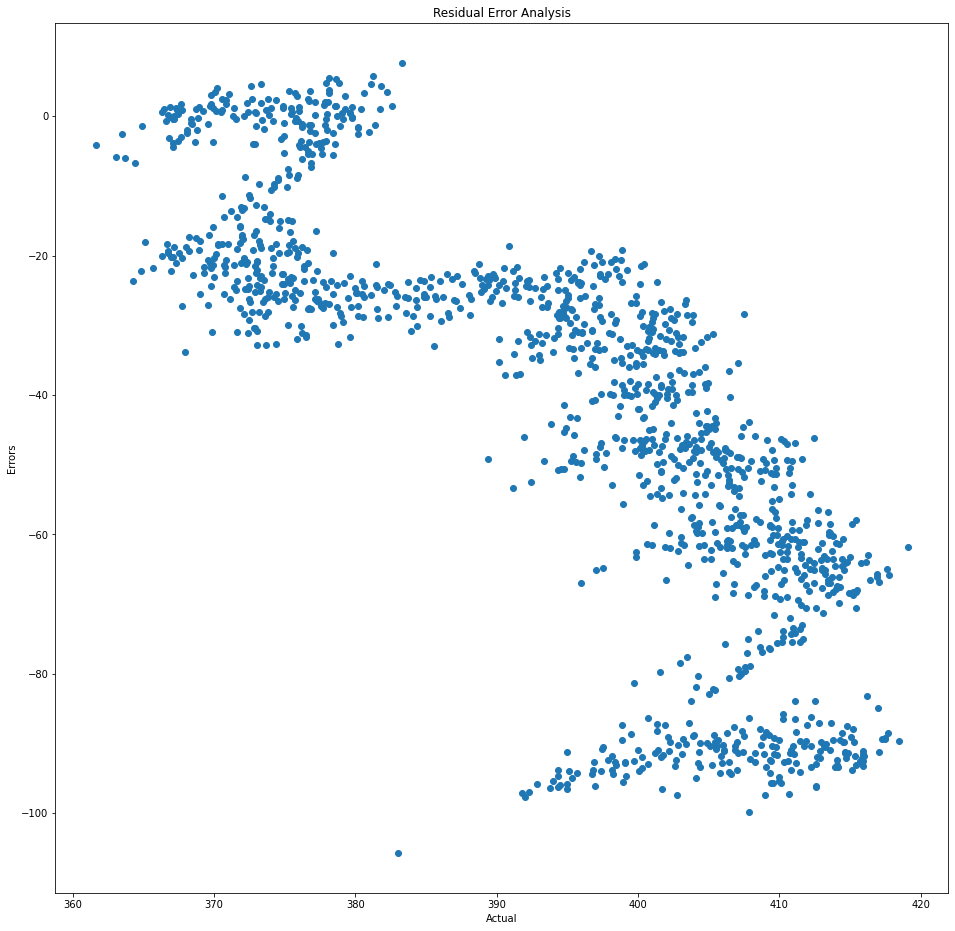

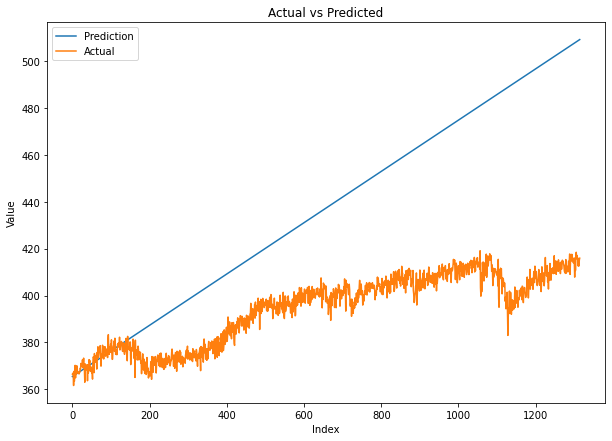

In [39]:
# Get actual values
actuals = test[input_target_variable].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)

elif input_ts_algo == 'manual_sarima':
    
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = train[input_target_variable], order = input_order, seasonal_order = input_seasonal_order)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)


If you had transformed the y variable, you need to inverse transform it back and then get the evaluation metric

-------------------------- Inverse transform the actual and predicted values and evaluate the model
------------- Model Evaluations --------------- 

MAPE :  413.46436709412825
MAE  :  5.303627689096316e+20
RMSE  :  8.213667218142715e+20
R2 Score  :  -355.3300056770626
Durbin Watson Score :  0.00025930106341798373


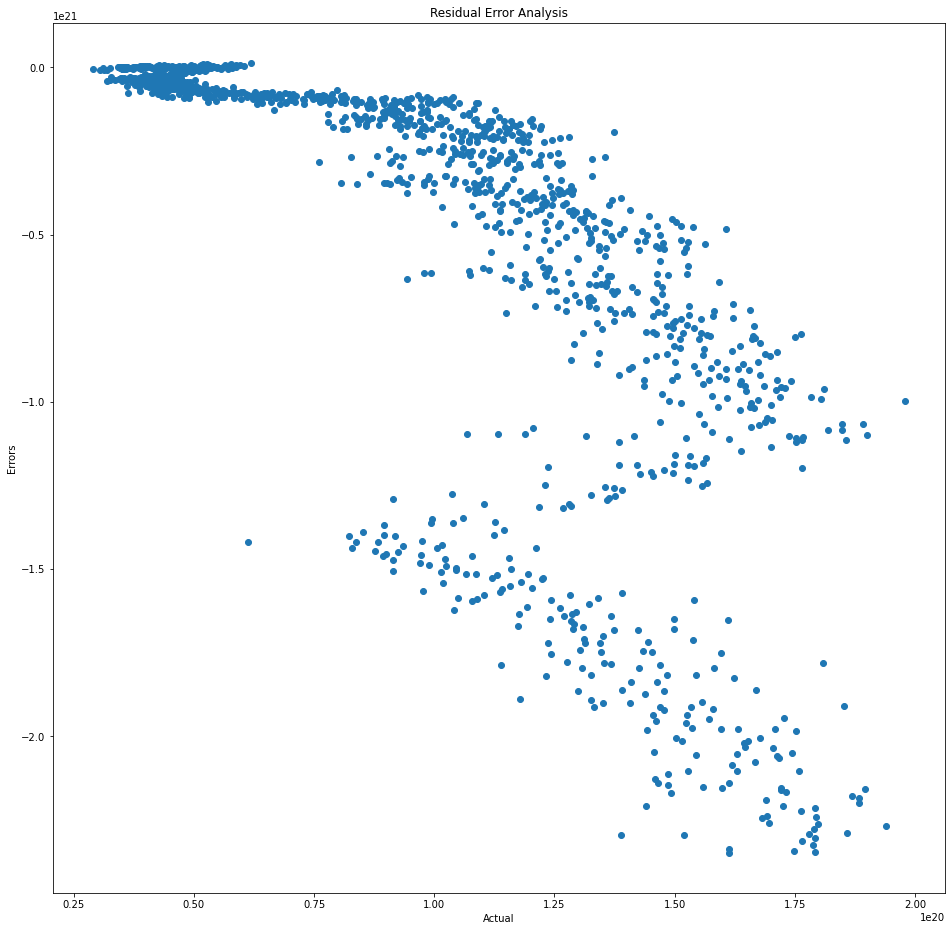

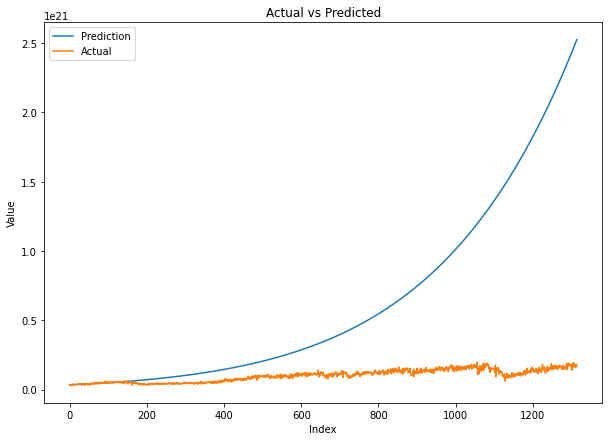

In [40]:
if input_transform_flag == 'Yes':
    print("-------------------------- Inverse transform the actual and predicted values and evaluate the model")
    actuals = inv_boxcox(actuals, my_lambda)
    predictions = inv_boxcox(predictions, my_lambda)
    evaluate_model(actuals, predictions)
else:
    print("No transformation")